In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Environment & traffic params
# -------------------------
T_p = 1             # time quantum (seconds)
L = 300             # bits/packet in queue
Q_max = 60          # threshold for high queue
Q_threshold = 40   # threshold for low queue
W_max = 300         # max bandwidth (units treated as service capacity per second)
cycles = 24         # number of cycles per episode (hours)
p_threshold_drop = 0.01  # packet drop probability threshold
p_threshold_vilotion = 0.1 # queue violation probability threshold
episodes = 1000 
W_levels = np.linspace(20, W_max, 25)

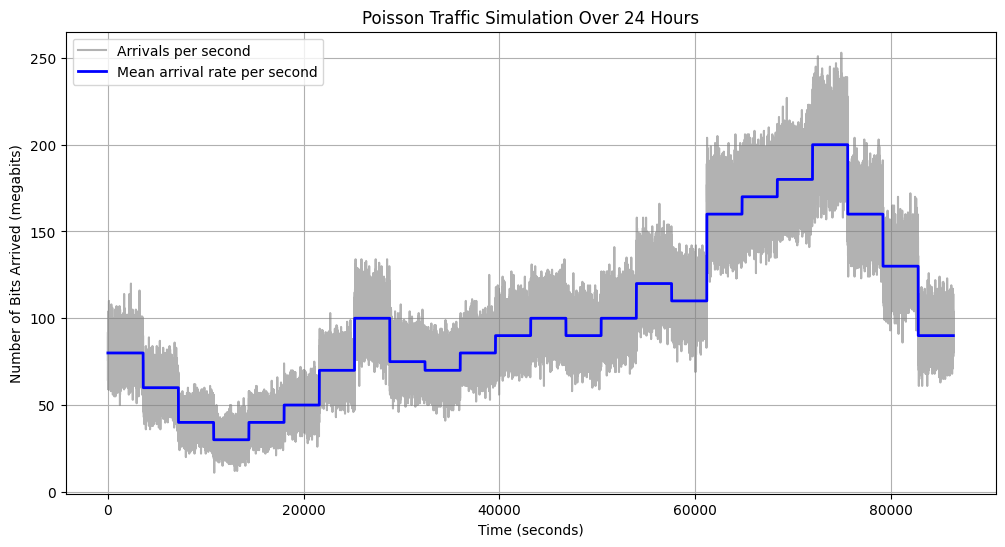

In [25]:
def generate_poisson_traffic(λ, duration):
    """
    Generate Poisson-distributed arrival times for a given mean rate (λ) and duration.

    Args:
        λ (float): Mean arrival rate (events per second).
        duration (int): Duration over which to simulate arrivals (seconds).

    Returns:
        np.ndarray: Array of arrival times (seconds) within the specified duration.
    """
    # Generate random numbers for inter-arrival times
    R = np.random.rand(int(λ * duration * 2))
    # Calculate inter-arrival times using inverse transform sampling
    IAT = -np.log(1 - R) / λ
    # Compute cumulative arrival times
    arrivals = np.cumsum(IAT)
    # Filter arrivals to only those within the specified duration
    return arrivals[arrivals <= duration]


mean_arrival_rates = np.array([80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90, 100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90,])

total_duration_day = 24 * 3600
arrivals_for_day = []

for hour, λ in enumerate(mean_arrival_rates):
    arrivals = generate_poisson_traffic(λ, 3600)
    arrivals += hour * 3600
    arrivals_for_day.extend(arrivals)

arrivals_for_day = np.array(arrivals_for_day)
time_bins = np.arange(0, total_duration_day + 1, 1)
bits_counts, _ = np.histogram(arrivals_for_day, bins=time_bins)

mean_per_second = np.repeat(mean_arrival_rates, 3600)

plt.figure(figsize=(12, 6))
plt.plot(time_bins[:-1], bits_counts, color="gray", alpha=0.6, label="Arrivals per second")
plt.plot(time_bins[:-1], mean_per_second, color="blue", linewidth=2, label="Mean arrival rate per second")
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Bits Arrived (megabits)")
plt.title("Poisson Traffic Simulation Over 24 Hours")
plt.legend()
plt.grid()
plt.show()

In [26]:
class LearningAgent:
    """
    Reinforcement Learning Agent for Dynamic Bandwidth Allocation using Q-Learning and SARSA.
    """

    def __init__(self, n_states=3, n_actions=25, alpha=0.1, gamma=0.2, epsilon=1.0, decay=0.99):
        # Q-table: shape (cycles, states, actions)
        self.Q = np.zeros((24, n_states, n_actions))
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.decay = decay      # Epsilon decay rate
        self.current_bandwidth = 0
        self.n_states = n_states
        self.n_actions = n_actions

    def update_queue(self, Q, arrivals, u, Q_max):
        """
        Update the queue length based on arrivals and allocated bandwidth.
        Args:
            Q (float): Current queue length.
            arrivals (int): Number of arriving packets.
            u (float): Allocated bandwidth.
            Q_max (int): Maximum queue length.
        Returns:
            float: Updated queue length.
        """
        new_packets = arrivals
        Q_new = Q + ((new_packets - u) * T_p / L)
        # Ensure queue stays within [0, Q_max + 1]
        return max(0, min(Q_new, Q_max + 1))

    def choose_action(self, state, cycle):
        """
        Select an action using epsilon-greedy policy.
        Args:
            state (int): Current state.
            cycle (int): Current cycle (hour).
        Returns:
            int: Selected action index.
        """
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = np.argmax(self.Q[cycle, state])
        self.current_bandwidth = W_levels[action]
        return action

    def update_epsilon(self):
        """
        Decay the exploration rate epsilon after each episode.
        """
        self.epsilon *= self.decay

    def update_sarsa(self, cycle, state, action, reward, next_state, next_action):
        """
        Update Q-table using SARSA algorithm.
        Args:
            cycle (int): Current cycle.
            state (int): Current state.
            action (int): Current action.
            reward (float): Received reward.
            next_state (int): Next state.
            next_action (int): Next action.
        """
        if cycle != 23:
            td_target = reward + self.gamma * self.Q[cycle + 1, next_state, next_action]
        else:
            td_target = reward
        self.Q[cycle, state, action] = (1 - self.alpha) * self.Q[cycle, state, action] + self.alpha * td_target

    def update_qlearning(self, cycle, state, action, reward, next_state):
        """
        Update Q-table using Q-Learning algorithm.
        Args:
            cycle (int): Current cycle.
            state (int): Current state.
            action (int): Current action.
            reward (float): Received reward.
            next_state (int): Next state.
        """
        if cycle != 23:
            td_target = reward + self.gamma * np.max(self.Q[cycle + 1, next_state])
        else:
            td_target = reward
        self.Q[cycle, state, action] = (1 - self.alpha) * self.Q[cycle, state, action] + self.alpha * td_target

    def printQ(self):
        """
        Print the Q-table for inspection.
        """
        print("\n===== Q-Table =====")
        for cycle in range(24):
            print(f"\nCycle {cycle}:")
            for state in range(self.Q.shape[1]):
                print(f"  State {state}: {self.Q[cycle][state]}")
        print("\n===================")

In [27]:
def QLearning():
    """
    Implements the Q-Learning algorithm for dynamic bandwidth allocation over multiple episodes.
    Returns:
        bandwidth_history (list): Total bandwidth used per episode.
        reward_history (list): Total reward obtained per episode.
    """

    reward_history = []
    bandwidth_history = []
    qLearningAgent = LearningAgent()

    for _ in range(episodes):
        Qlength = 0  # Initialize queue length for each episode
        total_reward = 0
        total_bandwidth = 0

        for cycle in range(cycles):
            Q_history = []

            # Determine the current state based on queue length
            if Qlength <= Q_threshold:
                state = 0
            elif Qlength < Q_max:
                state = 1
            else:
                state = 2

            # Select action using epsilon-greedy policy
            action = qLearningAgent.choose_action(state, cycle)
            u = int(qLearningAgent.current_bandwidth)

            # Simulate arrivals and update queue for each second in the cycle
            for second in range(3600):
                arrivals = bits_counts[(cycle * 3600) + second]
                Qlength = qLearningAgent.update_queue(Qlength, arrivals, u, Q_max)
                Q_history.append(Qlength)

            # Calculate statistics for reward computation
            Q_mean = np.mean(Q_history)
            p_violation = np.mean(np.array(Q_history) >= Q_threshold)
            p_drop = np.mean(np.array(Q_history) >= Q_max)

            # Reward function based on queue statistics and bandwidth usage
            if p_violation <= p_threshold_vilotion and p_drop <= p_threshold_vilotion:
                if qLearningAgent.current_bandwidth == 0:
                    reward = Q_mean
                else:
                    reward = Q_mean + (1 / qLearningAgent.current_bandwidth)
            elif (p_violation > p_threshold_vilotion and p_drop <= p_threshold_vilotion) or \
                 (p_violation <= p_threshold_vilotion and p_drop > p_threshold_vilotion):
                reward = 0
            else:
                reward = -1

            # Determine next state for Q-Learning update
            if Qlength <= Q_threshold:
                next_state = 0
            elif Qlength < Q_max:
                next_state = 1
            else:
                next_state = 2

            # Update Q-table using Q-Learning rule
            qLearningAgent.update_qlearning(cycle, state, action, reward, next_state)

            # Accumulate bandwidth and reward for the episode
            total_bandwidth += qLearningAgent.current_bandwidth
            total_reward += reward

        # Decay epsilon for exploration-exploitation tradeoff
        qLearningAgent.update_epsilon()
        reward_history.append(total_reward)
        bandwidth_history.append(total_bandwidth)

    return bandwidth_history, reward_history

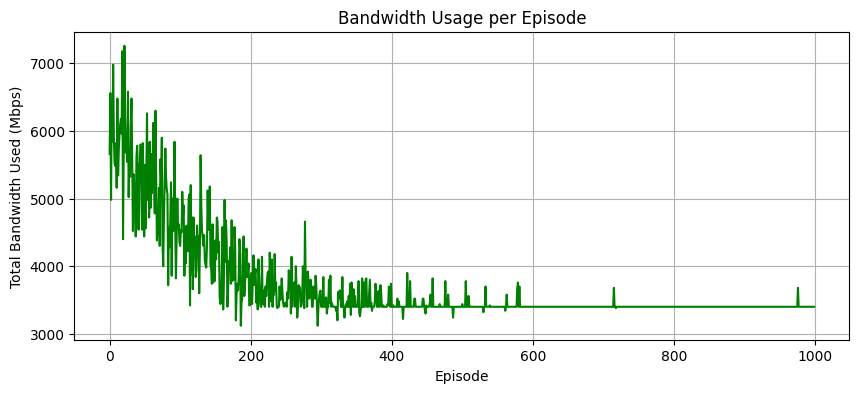

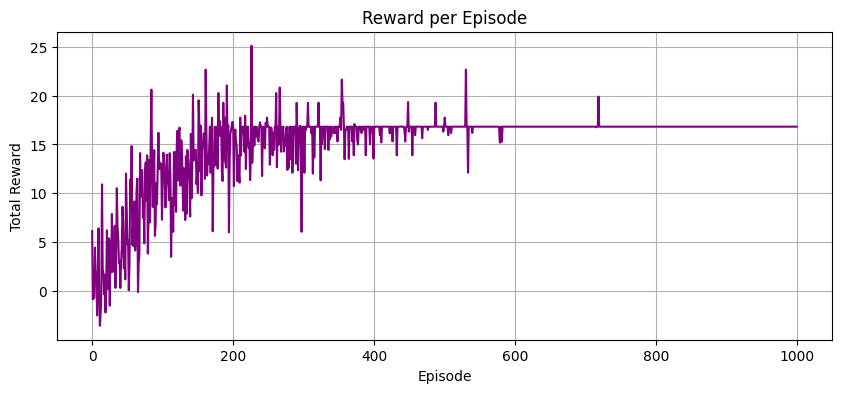

In [28]:
# Run Q-Learning to get bandwidth and reward per episode
bandwidth_per_episode, reward_per_episode = QLearning()

# Plot bandwidth per episode
plt.figure(figsize=(10, 4))
plt.plot(bandwidth_per_episode, color='green')
plt.xlabel('Episode')
plt.ylabel('Total Bandwidth Used (Mbps)')
plt.title('Bandwidth Usage per Episode')
plt.grid(True)
plt.show()

# Plot reward per episode
plt.figure(figsize=(10, 4))
plt.plot(reward_per_episode, color='purple')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.grid(True)
plt.show()

In [29]:
# Display the minimum bandwidth required and its corresponding reward from the last episode
min_bandwidth = bandwidth_per_episode[-1]
final_reward = reward_per_episode[-1]
print(f"Minimum Bandwidth Required: {min_bandwidth} Mbps (Final Episode)")
print(f"Corresponding Reward: {final_reward:.2f}")

Minimum Bandwidth Required: 3400.0 Mbps (Final Episode)
Corresponding Reward: 16.82
